In [2]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path

from dask import dataframe as dd
from functools import reduce
import matplotlib.pyplot as plt
import pickle
plt.rcParams['figure.dpi'] = 200
import sys


In [3]:
# find current working directoy
cwd_path = Path().absolute()
data_root = cwd_path.parent.parent / "data"
experiment = "cerebellum"
chrom_list = [f"chr{x}" for x in range(1, 20)]
chrom_list.append("chrX")

In [4]:
marker_list = ["SF3A66", "RNAPIISer5-P", "CPSF6", "H4K8ac", "H3K9ac", "CBP", "BRG1", "H3K27ac", "H3K36ac", "RYBP", "H3K4me2", "KAP1", "H3K4me3", "CHD4", "H4K16ac", "SOX2",
               "LaminB1", "n_per_dist(um)", "H3K27me2", "H3K27me3", "H4K20me3", "ATRX", "MajSat", "MinSat", "Fibrillarin", "mH2A1", "H3K9me3", "rDNA", "Telomere", 
              'ITS1_RNA', 'Rnu2_RNA', 'polyA_RNA', 'Malat1_RNA', 'HDAC2', 'H3K4me1', 'RNAPIISer2-P']
# define activate marker list
act_markers = ["SF3A66", "RNAPIISer5-P", "CPSF6", "H4K8ac", "H3K9ac", "CBP", "BRG1", "H3K27ac", "H3K36ac",
               "RYBP", "H3K4me2", "KAP1", "H3K4me3", "CHD4", "H4K16ac", "SOX2", 'HDAC2', 'H3K4me1', 'RNAPIISer2-P']
cell_types = ["Granule", "Bergmann", "MLI1", "Purkinje", "MLI2+PLI"]
chrom_list = [f"chr{x}" for x in range(1, 20)]
chrom_list.append("chrX")

# read in peak size
df = pd.read_csv(str(data_root /  experiment / "peak_detection" /"091623_peak_size_200kb.csv"))

In [5]:
df

,Unnamed: 0,peak_id,peak_size,cell_type,marker
0,0,0,34,Granule,SF3A66
1,35,1,23,Granule,SF3A66
2,59,2,42,Granule,SF3A66
3,102,3,24,Granule,SF3A66
4,127,4,34,Granule,SF3A66
...,...,...,...,...,...
27634,3614,229,5,MLI2+PLI,RNAPIISer2-P
27635,3620,230,9,MLI2+PLI,RNAPIISer2-P
27636,3630,231,21,MLI2+PLI,RNAPIISer2-P
27637,3652,232,7,MLI2+PLI,RNAPIISer2-P


In [6]:
# peak_info = {}
# for marker in marker_list:
    
#     print (marker)
#     if marker in act_markers:
#         output_pkl = f"./peak_detection/110822_version2_{marker}.pkl"
#     else:
#         output_pkl = f"./peak_detection/101822_update_{marker}.pkl"
    
#     with open(output_pkl, "rb") as f:
#         print (output_pkl)
#         output_dict = pickle.load(f)

#     info = {}
#     for ct in cell_types:
#         peak_dict = output_dict[ct]
#         m_peak_dfs = []

#         for chrom in chrom_list:
#             if chrom in peak_dict.keys():
#                 sls = peak_dict[chrom]
#                 sdf, peak, begin_intervals, m_intervals  = sls[0], sls[1], sls[2], sls[3].astype(int)
#     #             b_peak_start = sdf["start"].values[begin_intervals]
#                 m_peak_start = sdf["start"].values[m_intervals]

#     #             bp_df = pd.DataFrame(b_peak_start).T.rename(columns = {0 : "start", 1: "end"})
#                 mp_df = pd.DataFrame(m_peak_start).T.rename(columns = {0 : "start", 1: "end"})

#                 # make it
#                 mp_df["chrom"] = chrom
#                 mp_df["200kb start"] = mp_df["start"] // 200000
#                 mp_df["200kb end"] = mp_df["end"] // 200000
#                 m_peak_dfs.append(mp_df)


#             else:
#                 print (f"{marker} {chrom} {ct} not exist")
#         if len(m_peak_dfs) > 0:
#     #         b_peak_df = pd.concat(b_peak_dfs)
#             m_peak_df = pd.concat(m_peak_dfs)

#     #         b_peak_df["len"] = b_peak_df["end"] - b_peak_df["start"]
#             m_peak_df["len"] = m_peak_df["end"] - m_peak_df["start"]
#             info[ct] =  m_peak_df
#         else:
#             info[ct] = []
#     peak_info[marker] = info

# def melt_interval_df(tdf, thresh_bin = 8):
#     tdf["len"] = tdf["start"] - tdf["start"]
#     tdf["chrom_id"] = tdf["chrom"].str[3:].replace("X", 20).astype(int)

#     # define short/ long peaks according to chosen threshold
#     tdf["short peak"] = (tdf["len"] <= thresh_bin * 200000) * 1

#     tdf = tdf.sort_values(by = ["chrom_id", "start"])
#     tdf = tdf.reset_index(drop = True).reset_index().rename(columns = {"index" : "peak_id"})
#     bins = []
#     peak_ids = []
#     chroms = []
#     shorts = []
#     peak_len = []
#     for index, row in tdf.iterrows():
#         chrom = row["chrom"]
#         start = row["200kb start"]
#         end = row["200kb end"]
#         short = row["short peak"]
#         peak_id = row["peak_id"]
#         blist = list(range(start, end + 1))
#         peak_ids += [peak_id] * len(blist)
#         chroms += [chrom] * len(blist)
#         bins += blist
#         shorts += [short] * len(blist)
#         peak_len += [end - start] * len(blist)
#     final_peak = pd.DataFrame({"200kb bins" : bins, "peak_id" : peak_ids, "chrom" : chroms, "short" : shorts, "peak_size" : peak_len})
#     final_peak["200kb name"] = final_peak["chrom"] + '-g' + final_peak["200kb bins"].astype(str)
#     return final_peak

# final_peak_dict = {}
# for marker in marker_list:
#     final_info = {}
#     for ct in cell_types:
#         df = peak_info[marker][ct]
#         if len(df) > 0:
#             fdf = melt_interval_df(df, thresh_bin = 10)
#             final_info[ct] = fdf
#         else:
#             final_info[ct] = []
#     final_peak_dict[marker] = final_info

# # get the size dataframe
# all_dfs = []
# for marker in marker_list:
#     for ct in cell_types:

#         tdf = final_peak_dict[marker][ct].copy()
#         if len(tdf) != 0:
#             tdf = tdf[tdf["chrom"] != "chrX"][["peak_id", "peak_size"]].drop_duplicates()
#             tdf["cell_type"] = ct
#             tdf["marker"] = marker
#             all_dfs.append(tdf)
            

# df = pd.concat(all_dfs)
# df.to_csv("./peak_detection/091623_peak_size_200kb.csv")    

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 [Text(0, 0, 'SF3A66'),
  Text(1, 0, 'RNAPIISer5-P'),
  Text(2, 0, 'CPSF6'),
  Text(3, 0, 'H4K8ac'),
  Text(4, 0, 'H3K9ac'),
  Text(5, 0, 'CBP'),
  Text(6, 0, 'BRG1'),
  Text(7, 0, 'H3K27ac'),
  Text(8, 0, 'H3K36ac'),
  Text(9, 0, 'RYBP'),
  Text(10, 0, 'H3K4me2'),
  Text(11, 0, 'KAP1'),
  Text(12, 0, 'H3K4me3'),
  Text(13, 0, 'CHD4'),
  Text(14, 0, 'H4K16ac'),
  Text(15, 0, 'SOX2'),
  Text(16, 0, 'LaminB1'),
  Text(17, 0, 'n_per_dist(um)'),
  Text(18, 0, 'H3K27me2'),
  Text(19, 0, 'H3K27me3'),
  Text(20, 0, 'H4K20me3'),
  Text(21, 0, 'ATRX'),
  Text(22, 0, 'MajSat'),
  Text(23, 0, 'MinSat'),
  Text(24, 0, 'Fibrillarin'),
  Text(25, 0, 'mH2A1'),
  Text(26, 0, 'H3K9me3'),
  Text(27, 0, 'rDNA'),
  Text(28, 0, 'Telomere'),
  Text(29, 0, 'ITS1_RNA'),
  Text(30, 0, 'Rnu2_RNA'),
  Text(31, 0, 'polyA_RNA'),
  Text(32, 0, 'Mal

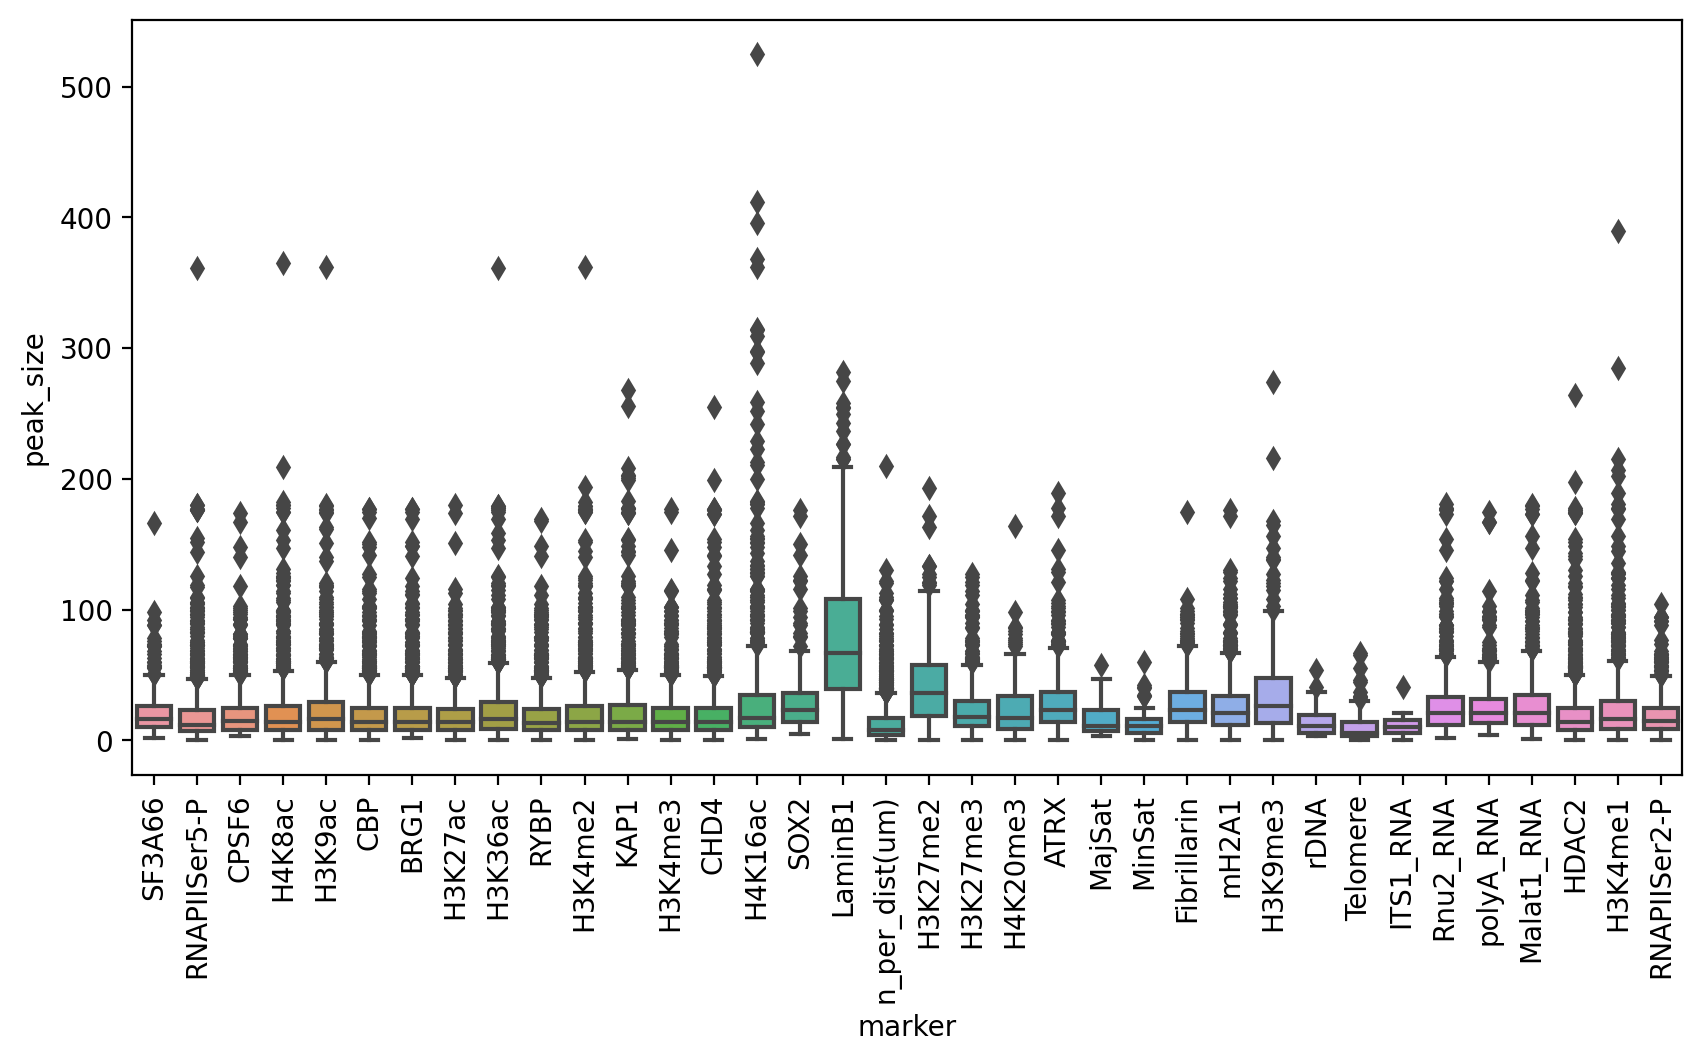

In [7]:
# plot the boxplot of peak size for all cell types including granule cells
plt.figure(figsize = (10, 5))
sns.boxplot(df, x = "marker", y = "peak_size")
plt.xticks(rotation=90)  # Rotate labels by 45 degrees



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 [Text(0, 0, 'SF3A66'),
  Text(1, 0, 'RNAPIISer5-P'),
  Text(2, 0, 'CPSF6'),
  Text(3, 0, 'H4K8ac'),
  Text(4, 0, 'H3K9ac'),
  Text(5, 0, 'CBP'),
  Text(6, 0, 'BRG1'),
  Text(7, 0, 'H3K27ac'),
  Text(8, 0, 'H3K36ac'),
  Text(9, 0, 'RYBP'),
  Text(10, 0, 'H3K4me2'),
  Text(11, 0, 'KAP1'),
  Text(12, 0, 'H3K4me3'),
  Text(13, 0, 'CHD4'),
  Text(14, 0, 'H4K16ac'),
  Text(15, 0, 'SOX2'),
  Text(16, 0, 'LaminB1'),
  Text(17, 0, 'n_per_dist(um)'),
  Text(18, 0, 'H3K27me2'),
  Text(19, 0, 'H3K27me3'),
  Text(20, 0, 'H4K20me3'),
  Text(21, 0, 'ATRX'),
  Text(22, 0, 'MajSat'),
  Text(23, 0, 'MinSat'),
  Text(24, 0, 'Fibrillarin'),
  Text(25, 0, 'mH2A1'),
  Text(26, 0, 'H3K9me3'),
  Text(27, 0, 'rDNA'),
  Text(28, 0, 'Telomere'),
  Text(29, 0, 'ITS1_RNA'),
  Text(30, 0, 'Rnu2_RNA'),
  Text(31, 0, 'polyA_RNA'),
  Text(32, 0, 'Mal

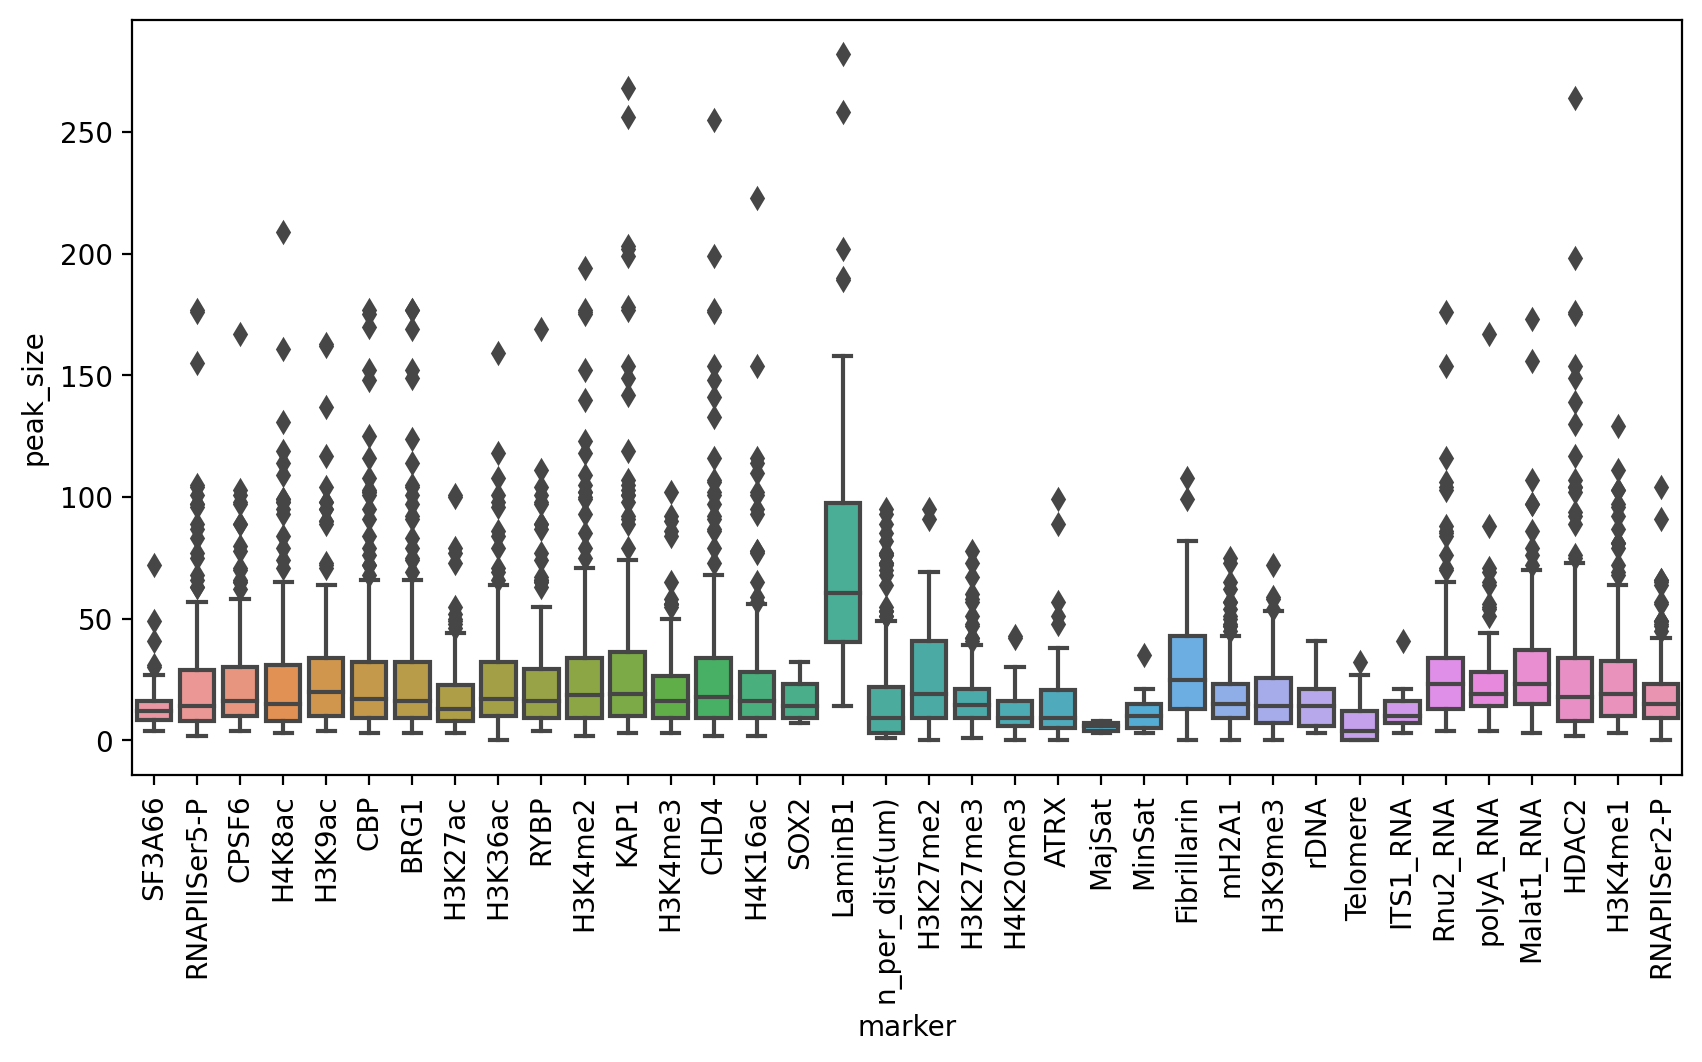

In [8]:
# you can also select certain cell type
check_ct = "Purkinje"
plt.figure(figsize = (10, 5))
sns.boxplot(df[df["cell_type"] == check_ct ], x = "marker", y = "peak_size")
plt.xticks(rotation=90)  # Rotate labels by 45 degrees